# Standalone Driver of Neural ODE

In [1]:
import math
import numpy as np

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F

import matplotlib.pyplot as plt
# %matplotlib inline

adjoint = False
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

from ode_AM_index_config import hyp_param
#from ode_AM_index_config import plot_red_noise as plot
from ode_AM_index_config import LinearFunc, DpTanhFunc, TanhFunc, SoftplusFunc, LeakyReLuFunc


In [2]:
def plot_red_noise(t, y, lag_time=30, gamma=None, model=None):
    from ode_nn_mod import OdeModel

    lags = np.linspace(-lag_time, lag_time, 2*lag_time+1)
    
    u = np.squeeze(y.detach().numpy())
    data_size = len(u)
    Cu = np.array([np.trace(u[0:data_size-lag].T @ u[lag:])/(data_size-lag) for lag in np.arange(0, lag_time+1)])
    Cov_u = np.hstack((Cu[-1::-1], Cu[1:]))
    
    fig1 = plt.figure(figsize=(12,5))
    ax1 = fig1.add_subplot(1,2,1)
    ax1.plot(lags, Cov_u/Cov_u[lag_time], '-b', label='true C(u)')
    if gamma is not None and len(gamma)==1:
        ax1.plot(lags, np.exp(-abs(lags)*gamma), '--k', label='exp(-gamma|t|)')
    
    if model is not None:
        with torch.no_grad():
            if isinstance(model, OdeModel):
                #call OdeModel method directly
                #print('\n', model.func)
                u2= np.squeeze(model(y[:data_size-lag_time-1], t[:lag_time+1]).detach().numpy())
            else:
                func = model
                if hyp_param['ode']['adjoint']:
                    from torchdiffeq import odeint_adjoint as odeint
                else:
                    from torchdiffeq import odeint
                #integrate func using odeint
                #print('\n', func)
                u2 = np.squeeze(odeint(func, y[:data_size-lag_time-1], t[:lag_time+1]).detach().numpy())
        
        Cu2 = np.array([np.trace(u2[0,:].T @ u2[lag,:])/(data_size-lag_time-1) for lag in np.arange(0, lag_time+1)])

        Cov_u2 = np.hstack((Cu2[-1::-1], Cu2[1:]))
        ax1.plot(lags, Cov_u2/Cov_u2[lag_time], '--r', label='predicted C(u)')

        """
        ax2 = fig1.add_subplot(1,2,2)
        Cu3 = np.array([np.corrcoef(u[lag:data_size-lag_time-1+lag], u2[lag,:].T)[0, 1] for lag in np.arange(0, lag_time+1)])
        Cor_u3 = np.hstack((Cu3[-1::-1], Cu3[1:]))
        ax2.plot(lags, Cov_u/Cov_u[lag_time], '-b', label='true C(u)')
        ax2.plot(lags, Cor_u3, '--r', label='corr(true, predicted)')
        ax2.set_xlim(-lag_time, lag_time)
        ax2.legend()
        """

    ax1.set_xlim(-lag_time, lag_time)
    ax1.legend()

plot = plot_red_noise

Reading from saved data ......
Use pressure levels = [   1.    2.    3.    5.    7.   10.   20.   30.   50.   70.  100.  125.
  150.  175.  200.  225.  250.  300.  350.  400.  450.  500.  550.  600.
  650.  700.  750.  775.  800.  825.  850.  875.  900.  925.  950.  975.
 1000.]

torch.Size([21535]) torch.Size([21535, 1, 37])

 TanhFunc(
  (net): Sequential(
    (0): Linear(in_features=37, out_features=5, bias=True)
    (1): Tanh()
    (2): Linear(in_features=5, out_features=37, bias=True)
  )
)


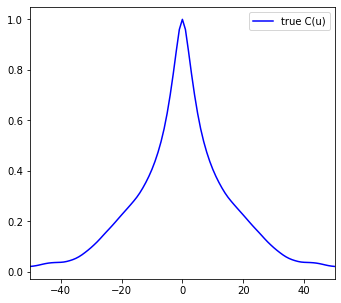

In [3]:
lag_time = 50
if False:
# red noise
    from ode_AM_index_config import get_red_noise as get_data
    gamma = [0.06]
    t, true_y = get_data(gamma=gamma, data_size=10000)
    plot(t, true_y, gamma=gamma, lag_time=lag_time)
else:
# annular mode
    from ode_AM_index_config import get_AM_index as get_data
    t, true_y = get_data()
    #t, true_y = get_data(p_levels = [10, 500])
    plot(t, true_y, lag_time=lag_time)

print(t.shape, true_y.shape)

#=============================================================
#func = LinearFunc(true_y.shape[2], true_y.shape[2])
#func = DpTanhFunc(true_y.shape[2], 5, true_y.shape[2])
func = TanhFunc(true_y.shape[2], 5, true_y.shape[2])
#func = SoftplusFunc(true_y.shape[2], 5, true_y.shape[2])
#func = LeakyReLuFunc(true_y.shape[2], 5, true_y.shape[2])

print('\n', func)

In [4]:
niters = 1000 # 500
data_size = len(true_y)
batch_size = 100 # 20
batch_time = 10 # 10
output_freq = 100
learning_rate = 1e-3

#loss_fn = nn.L1Loss()
loss_fn = nn.MSELoss()
optimizer = optim.RMSprop(func.parameters(), lr=learning_rate)

def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

batch_y0, batch_t, batch_y = get_batch()
print(batch_y0.shape, batch_t.shape, batch_y.shape)

torch.Size([100, 1, 37]) torch.Size([10]) torch.Size([10, 100, 1, 37])


Iter  100 | Loss 0.403905
Iter  200 | Loss 0.409981
Iter  300 | Loss 0.419656
Iter  400 | Loss 0.509798
Iter  500 | Loss 0.453071
Iter  600 | Loss 0.459781
Iter  700 | Loss 0.461716
Iter  800 | Loss 0.356954
Iter  900 | Loss 0.461765
Iter 1000 | Loss 0.429736


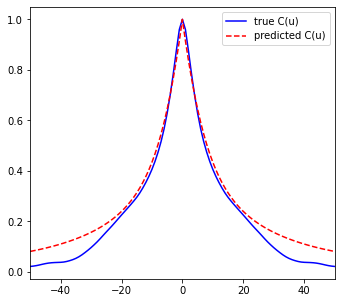

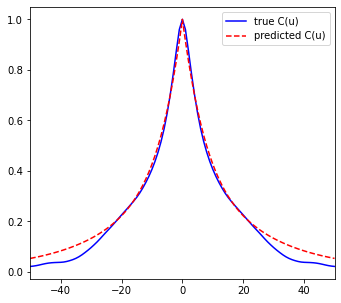

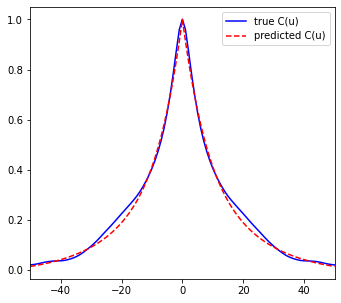

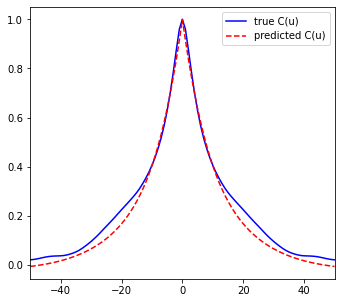

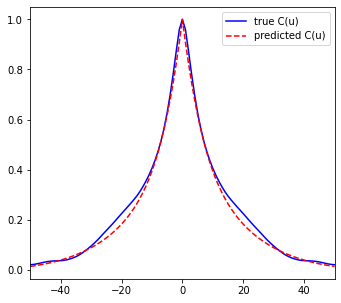

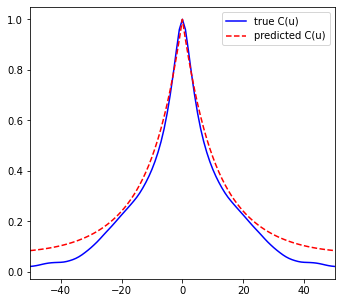

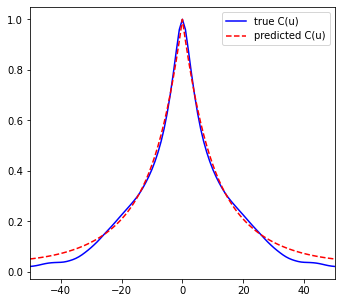

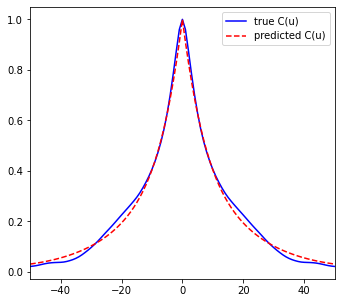

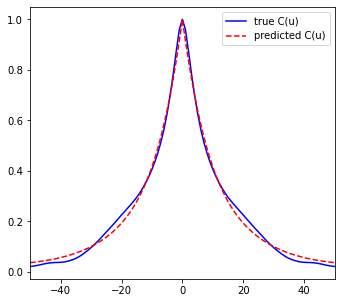

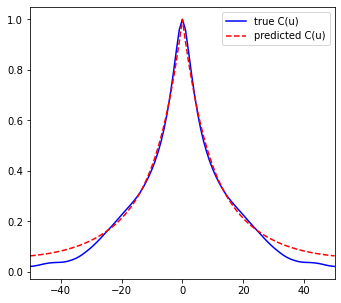

In [10]:
class OdeRun():
    
    def __init__(self):
        self.save = {}
        
    def log(self, key, value, append_value=True):
        if (key in self.save) and append_value:
            self.save[key].append(value)
        else:
            self.save[key] = [value]
    
    def run(self):
        ii = 0
        for itr in range(1, niters + 1):
            batch_y0, batch_t, batch_y = get_batch()
            pred_y = odeint(func, batch_y0, batch_t)
            loss = loss_fn(pred_y, batch_y)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                self.log('loss', loss.item())
                for name, param in func.named_parameters():
                    #print(f'{name:} {param.detach().numpy()}')
                    self.log(name, param.clone().detach().numpy())
                
                if itr % output_freq == 0:
                    print(f'Iter {itr:>4d} | Loss {loss.item():>8f}')
                    plot(t, true_y, model=func, lag_time=lag_time)
                    ii += 1

r = OdeRun()
r.run()

In [11]:
print(r.save.keys())

dict_keys(['loss', 'net.0.weight', 'net.0.bias', 'net.2.weight', 'net.2.bias'])


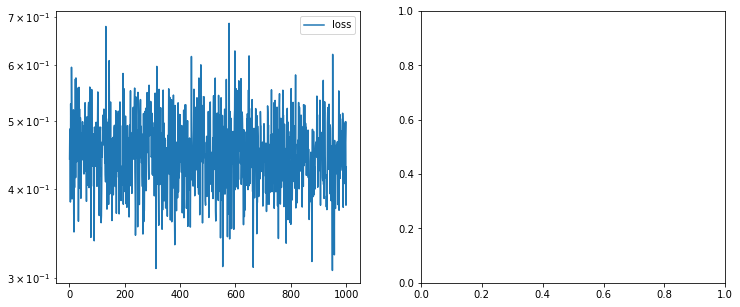

In [12]:
tt = np.linspace(1, niters, niters)

fig1 = plt.figure(figsize=(12,5))
ax1 = fig1.add_subplot(1,2,1)
ax1.plot(tt, r.save['loss'], label='loss')
ax1.legend()
plt.yscale("log")

ax1 = fig1.add_subplot(1,2,2)
#ax1.plot(tt, np.squeeze(np.array(r.save['net.0.weight'])[:,:,0]), label='weight')
#ax1.plot(tt, np.squeeze(np.array(r.save['net.0.bias'])), label='bias')
#ax1.legend()


net.0.weight:Parameter containing:
tensor([[-0.2080,  0.0368,  0.1894,  0.0803,  0.0921, -0.0591,  0.0374, -0.1086,
         -0.0905,  0.0854,  0.1743,  0.2192, -0.1289, -0.0080, -0.1840, -0.0896,
         -0.0935, -0.2147,  0.0672, -0.0077, -0.0561, -0.0180, -0.1182, -0.0661,
          0.0424, -0.0998,  0.0656,  0.0424, -0.0031,  0.1025,  0.0687,  0.0826,
          0.0945, -0.0367, -0.0830, -0.1153,  0.0657],
        [-0.1510,  0.2969, -0.0734, -0.0263,  0.1255, -0.0355, -0.0531, -0.0963,
          0.0660, -0.0921,  0.0585, -0.1389,  0.0328,  0.1639, -0.0726,  0.1308,
         -0.0472,  0.0233, -0.0075,  0.0293, -0.1010,  0.0263,  0.0894, -0.2727,
         -0.1326,  0.1015, -0.0421,  0.0782,  0.0153,  0.0043, -0.0241,  0.1405,
          0.0712,  0.0527, -0.1765, -0.0446,  0.0729],
        [-0.0342, -0.0390,  0.1083,  0.2102, -0.1718, -0.0250,  0.0496, -0.2006,
          0.0010,  0.1092, -0.0399,  0.0333,  0.0388,  0.0139,  0.1145, -0.2211,
          0.1143, -0.1039, -0.0014, -0.0682,

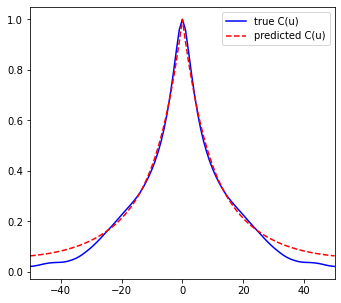

In [13]:
plot(t, true_y, model=func, lag_time=lag_time)
for name, param in func.named_parameters():
    print(f'\n{name}:{param}')

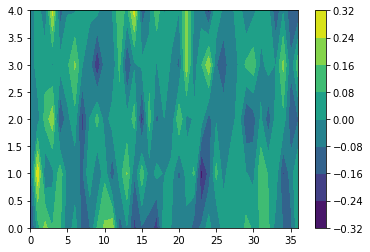

In [14]:
ax=plt.contourf(np.array(r.save['net.0.weight'])[-1,:,:])
plt.colorbar(ax)
